**Imports**

In [1]:
from imports import * 
from functions import *
from archs import *
from mylearner import *
%matplotlib inline
%load_ext tensorboard

**Loading annotated data**

In [2]:
from loading_data import *

data shape: (64171, 23)
        oxygen      pm10     co  temperature    co2    so2    no2       pm1  \
0      20.936  0.548238  1.562       24.276  455.7  -1.96  23.93  0.396847   
1      20.938  0.678546  1.562       24.274  454.4  -2.06  23.90  0.375806   
2      20.937  0.788452  1.562       24.273  454.5  -2.39  23.96  0.447566   
3      20.937  0.890764  1.562       24.271  454.5  -2.69  23.87  0.558607   
4      20.937  0.844628  1.562       24.268  455.0  -2.83  23.90  0.570323   
...       ...       ...    ...          ...    ...    ...    ...       ...   
44440  20.233  1.471562  1.472       18.350  448.2  25.15  23.51  1.103393   
44441  20.234  1.476924  1.472       18.350  448.3  25.02  23.44  1.049043   
44442  20.233  1.373389  1.472       18.351  449.4  25.04  23.49  1.043940   
44443  20.233  1.454923  1.472       18.350  448.8  25.06  23.57  1.065992   
44444  20.233  1.249064  1.471       18.348  449.2  24.99  23.69  1.031303   

        dewpt      timestamp  ...     

**Encode target classes (person and window open) classes**

In [3]:
df1 = encode_classes(d1)
df2 = encode_classes(d2)
df = encode_classes(data)

0    18144
1     1440
2      139
4        2
3        1
Name: person, dtype: int64
0    18701
1     1025
Name: window_open, dtype: int64
(19726, 23)
0    43791
1      604
2       50
Name: person, dtype: int64
0    44156
1      289
Name: window_open, dtype: int64
(44445, 23)
0    61935
1     2044
2      189
4        2
3        1
Name: person, dtype: int64
0    62857
1     1314
Name: window_open, dtype: int64
(64171, 23)


**select some columns to plot**

[Text(0, 0, '1314'),
 Text(0, 0, '62857'),
 Text(0, 0, '61935'),
 Text(0, 0, '2044'),
 Text(0, 0, '189'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

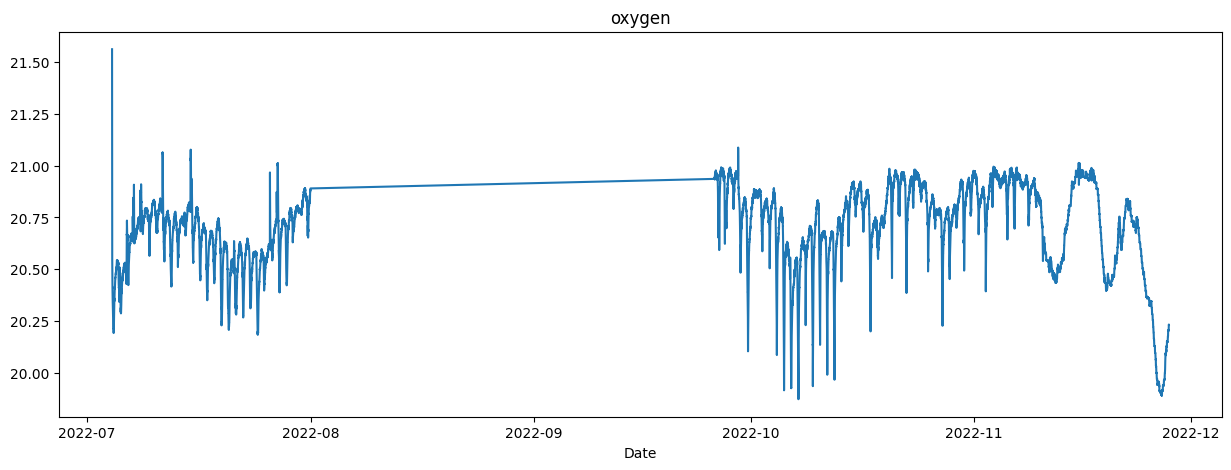

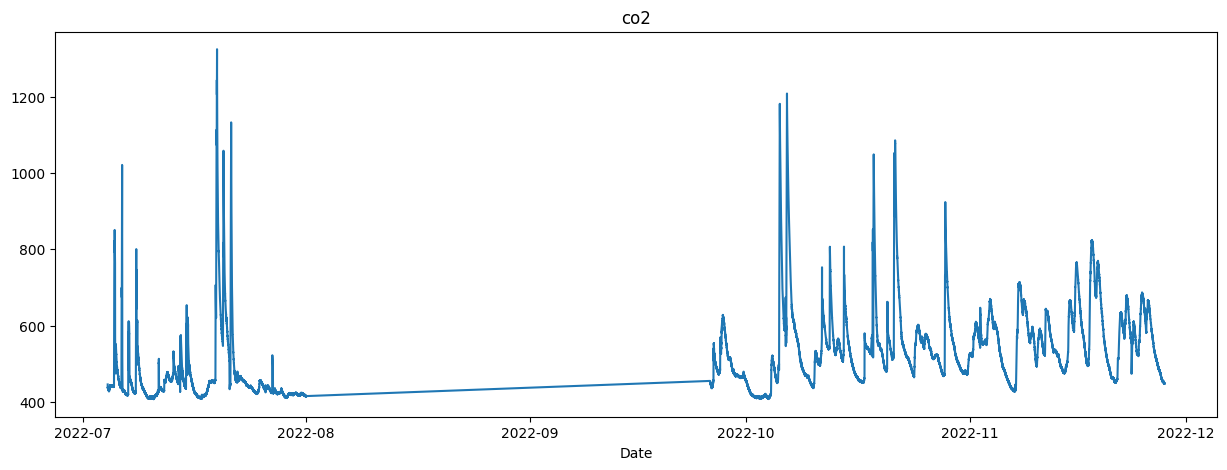

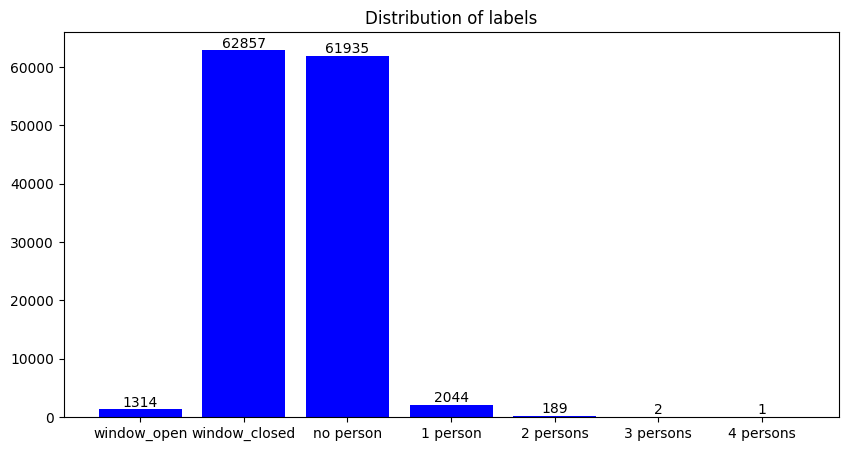

In [4]:
plot_cols = ['oxygen', 'co2','person','window_open']

x = df.datetime

# plot o2 and co2 
for col in plot_cols[0:2]:
    fig = plt.figure(figsize=(15,5))
    plt.plot(x, df[col])
    plt.xlabel('Date')
    plt.title(col)

#plot distribution of number of persons and window open

x_lbs = ['window_open','window_closed','no person','1 person','2 persons','3 persons','4 persons']
y_nmrs = [df['window_open'].value_counts()[1],df['window_open'].value_counts()[0],df['person'].value_counts()[0],df['person'].value_counts()[1],df['person'].value_counts()[2],df['person'].value_counts()[4],df['person'].value_counts()[3]]

fig, ax = plt.subplots(figsize=(10,5))    
ind = np.arange(len(y_nmrs))  # the x locations for the groups
bars = ax.bar(ind, y_nmrs, color="blue")
ax.set_xticks(ind)
ax.set_xticklabels(x_lbs, minor=False)
plt.title('Distribution of labels')
# plt.grid(linestyle = '--')
# plt.xlabel('x')
# plt.ylabel('y')
ax.bar_label(bars)



# for col in plot_cols[2:]:
#     fig = plt.figure()
#     plt.hist(df[col],label='Test set distribution')
#     plt.xlabel(f'\n {col}')
# ## Ticks labels - List must be in ascending order
#     plt.xticks(df[col].unique()) ### names of classes starting from 0
#     #sns.distplot(df[col], bins=100, kde=False)
#     plt.title(f'Distribution of {col}')
#     plt.legend()
#     plt.show()
#     # plt.figure()
#     # df[col].value_counts().plot.pie(autopct='%0.2f')



**plot scaled data in one figure**

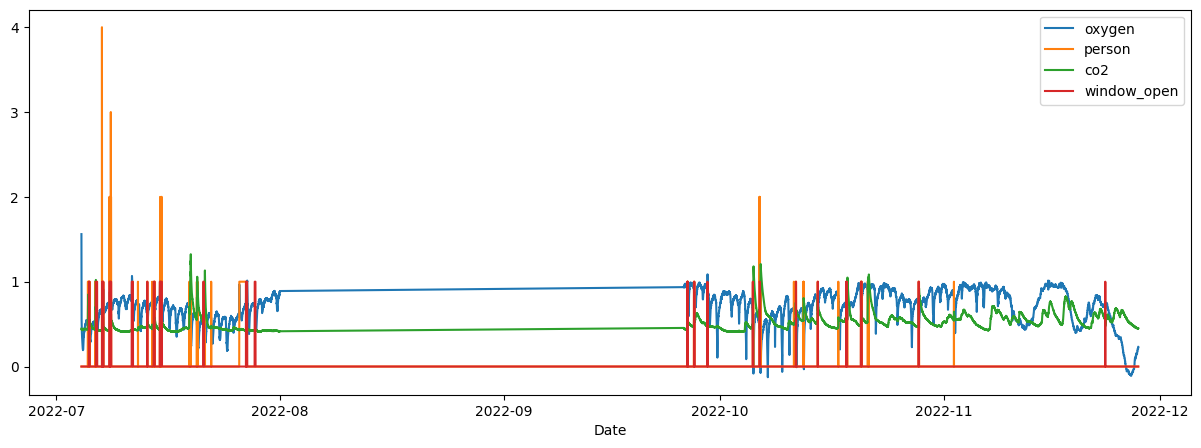

In [5]:
x = df.datetime
fig = plt.figure(figsize=(15,5))

plt.xlabel('Date')
plt.plot(x, df['oxygen']-20,label='oxygen')
plt.plot(x, df['person'],label='person')
plt.plot(x, df['co2']/1000,label='co2')
plt.plot(x, df['window_open'], label='window_open' )
plt.legend()


**filtering data**

In [6]:
# h2s column has only NaN values, also drop timestamp,datetime,deviceid
df.drop(columns=['h2s','timestamp','deviceid','datetime'],inplace=True)
df1.drop(columns=['h2s','timestamp','deviceid','datetime'],inplace=True)
df2.drop(columns=['h2s','timestamp','deviceid','datetime'],inplace=True)

**Missing values, drop NAN**

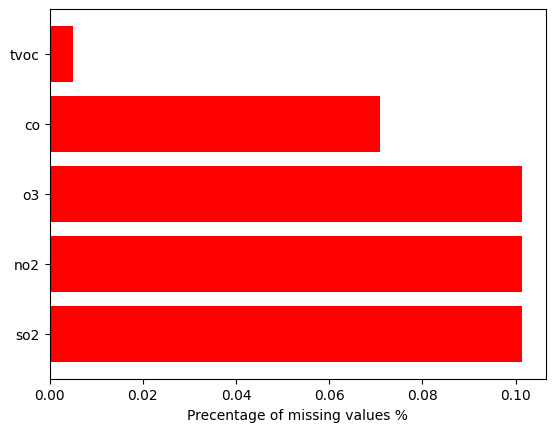

maximum number of missing values per column=  20 

   column  count  percentage
5     so2     20    0.101389
6     no2     20    0.101389
12     o3     20    0.101389
2      co     14    0.070972
9    tvoc      1    0.005069


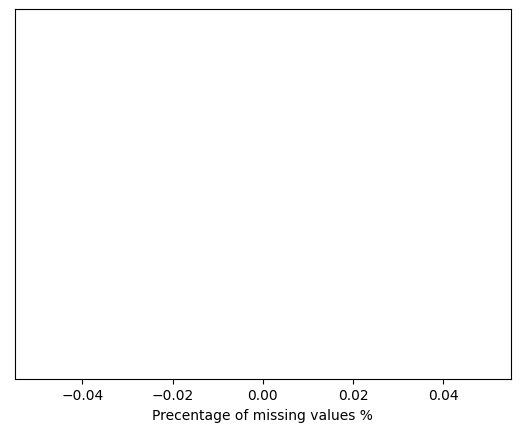

maximum number of missing values per column=  nan 

Empty DataFrame
Columns: [column, count, percentage]
Index: []


In [7]:
plot_missing(df1)
plot_missing(df2)

#### substitute NaN values with mean 
## polynomial interpolation with degree > 1 uses index, also convert dtype to float to work
impute_NaN(df1)
impute_NaN(df2)

############## conmibe into df 

df = concat(df1,df2)
df.reset_index(drop=True,inplace= True)
df.columns=df1.columns

**minimized dataset for our classification task, drop  rows for testing**

In [8]:

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')

#### combine classes of more than 1 person to 1 person as there exists too little of them
lc = df.loc[lambda x: x['person'] > 1]
df.loc[lc.index,'person'] = 1

lc = df1.loc[lambda x: x['person'] > 1]
df1.loc[lc.index,'person'] = 1

lc = df2.loc[lambda x: x['person'] > 1]
df2.loc[lc.index,'person'] = 1

print(df['person'].value_counts(),'\n',df['window_open'].value_counts(),'\n')


############### drop  rows for testing
### november (one month) for testing
# df2_test = df2.iloc[df2.shape[0]-22000:df2.shape[0]-21700] ## to get better visualization on less focused data
# df2 = df2.drop(index = df2.index[df2.shape[0]-22000:]) ### to keep the sequence order drop from last

### end of september (~ 10 days ) for testing
df2_test = df2.iloc[7300:7500]## to get better visualization on less focused data
df2 = df2.drop(index = df2.index[:7500]) ### to keep the sequence order drop from last

### end of August (~ 5 days ) for testing
# df1_test = df1.iloc[df1.shape[0]-3500:df1.shape[0]-3200]## to get better visualization on less focused data
# df1 = df1.drop(index = df1.index[df1.shape[0]-3500:]) ### to keep the sequence order drop from last


### first of July (~ 1-2 days ) for testing
# df1_test = df1.iloc[600:800]## to get better visualization on less focused data
# df1 = df1.drop(index = df1.index[:800]) ### to keep the sequence order drop from last

df2.reset_index(drop=True,inplace=True)
df2_test.reset_index(drop=True,inplace=True)

df2_test_targets = df2_test.filter(['person','window_open'])
df2_test_features = df2_test.drop(columns=['person','window_open']) 


# #### remove rows with 3 (one row) and 4 person (2 rows)
# lc = df.loc[lambda x: x['person'] == 3]
# df.drop(lc.index,inplace=True)

# lc = df.loc[lambda x: x['person'] == 4]
# df.drop(lc.index,inplace=True)

# df['person'].value_counts(),df['window_open'].value_counts()



targets = df.filter(['person','window_open'])
features = df.drop(columns=['person','window_open']) 


targets1 = df1.filter(['person','window_open'])
features1 = df1.drop(columns=['person','window_open']) 

targets2 = df2.filter(['person','window_open'])
features2 = df2.drop(columns=['person','window_open']) 



### minimized data
# l_ = ['humidity','temperature','tvoc','oxygen','co2','co','pressure','o3','sound','person','window_open']
# f_ = ['humidity','temperature','tvoc','oxygen','co2','co','pressure','o3','sound']
### from leipzig
l_ = ['humidity_abs','temperature','tvoc','oxygen','co2','co','no2','o3','person','window_open']
f_ = ['humidity_abs','temperature','tvoc','oxygen','co2','co','no2','o3']
df_mini1 = df1.filter(l_)
print(df_mini1.shape,'\n',df_mini1['person'].value_counts(),'\n',df_mini1['window_open'].value_counts(),'\n')
features_mini1 = features1.filter(f_)
# print(targets1.iloc[:,0].value_counts())

df_mini2 = df2.filter(l_)
print(df_mini2.shape,'\n',df_mini2['person'].value_counts(),'\n',df_mini2['window_open'].value_counts(),'\n')
features_mini2 = features2.filter(f_)
# print(targets2.iloc[:,0].value_counts())

df2_test_mini = df2_test.filter(l_)
print(df2_test_mini.shape,'\n',df2_test_mini['person'].value_counts(),'\n',df2_test_mini['window_open'].value_counts(),'\n')
df2_test_features_mini = df2_test_features.filter(f_)

## whole df
df_mini = df.filter(l_)
print(df_mini.shape,'\n',df_mini['person'].value_counts(),'\n',df_mini['window_open'].value_counts(),'\n')
features_mini = features.filter(f_)
# print(targets2.iloc[:,0].value_counts())


0.0    61915
1.0     2044
2.0      189
4.0        2
3.0        1
Name: person, dtype: int64 
 0.0    62837
1.0     1314
Name: window_open, dtype: int64 

0.0    61915
1.0     2236
Name: person, dtype: int64 
 0.0    62837
1.0     1314
Name: window_open, dtype: int64 

(19706, 10) 
 0    18124
1     1582
Name: person, dtype: int64 
 0    18681
1     1025
Name: window_open, dtype: int64 

(36945, 10) 
 0    36409
1      536
Name: person, dtype: int64 
 0    36704
1      241
Name: window_open, dtype: int64 

(200, 10) 
 0    175
1     25
Name: person, dtype: int64 
 0    179
1     21
Name: window_open, dtype: int64 

(64151, 10) 
 0.0    61915
1.0     2236
Name: person, dtype: int64 
 0.0    62837
1.0     1314
Name: window_open, dtype: int64 



**Correlation Matrix, drop highly correlated features**

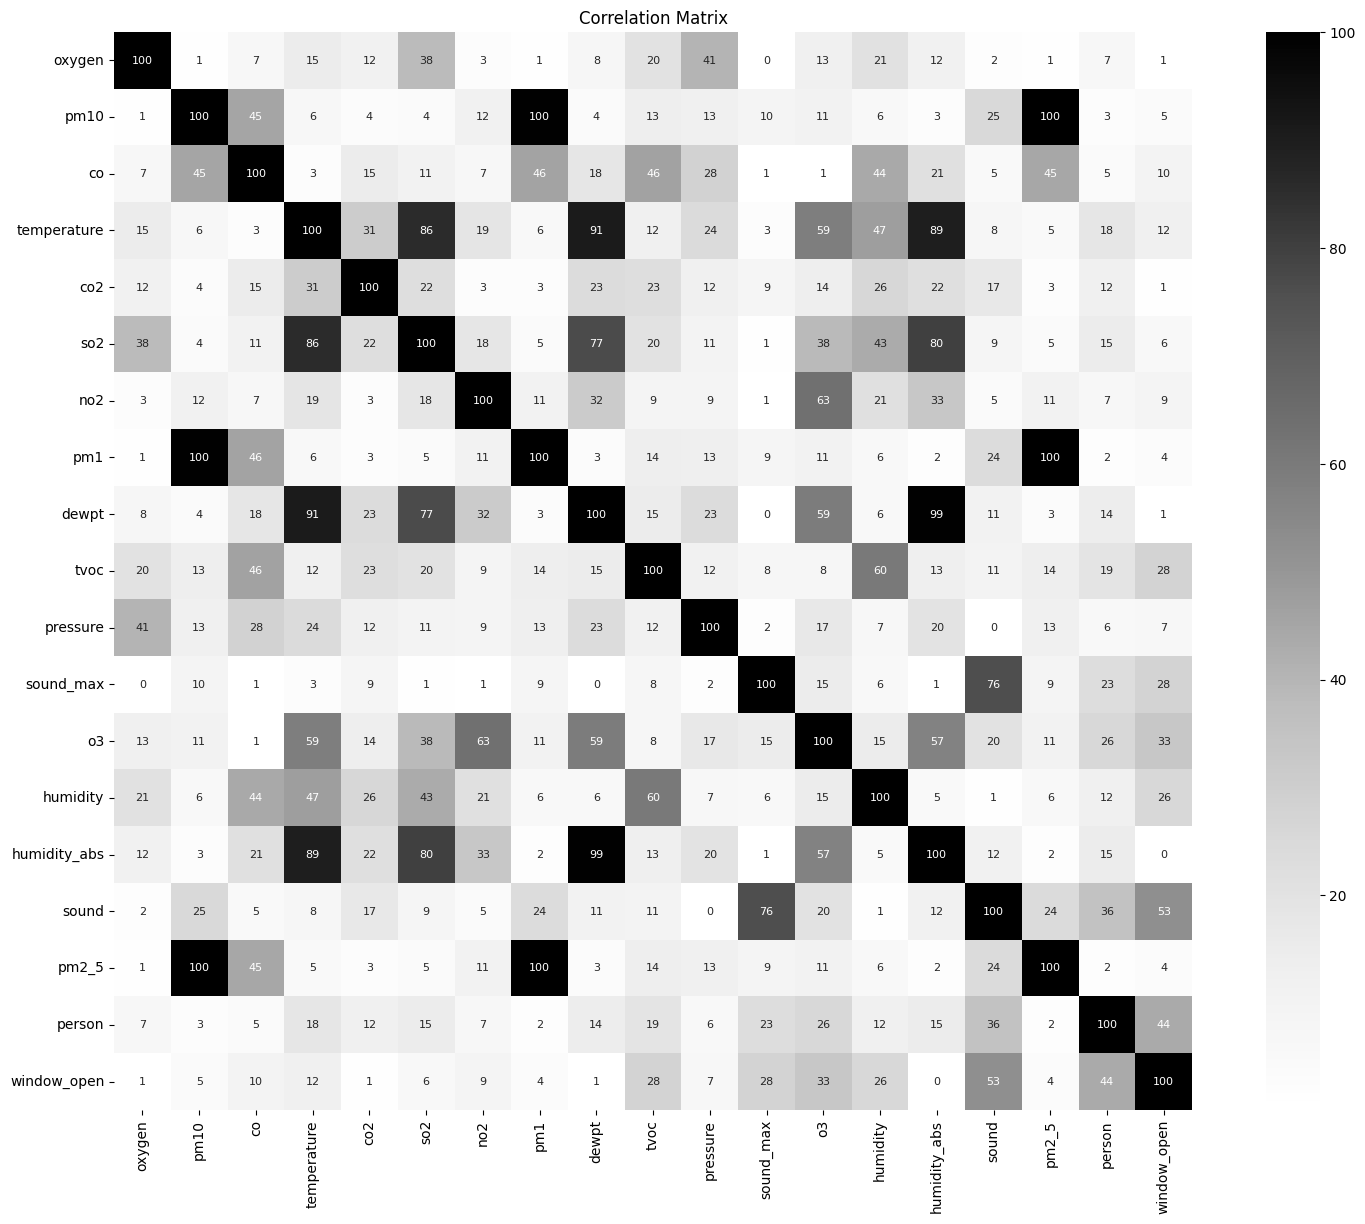

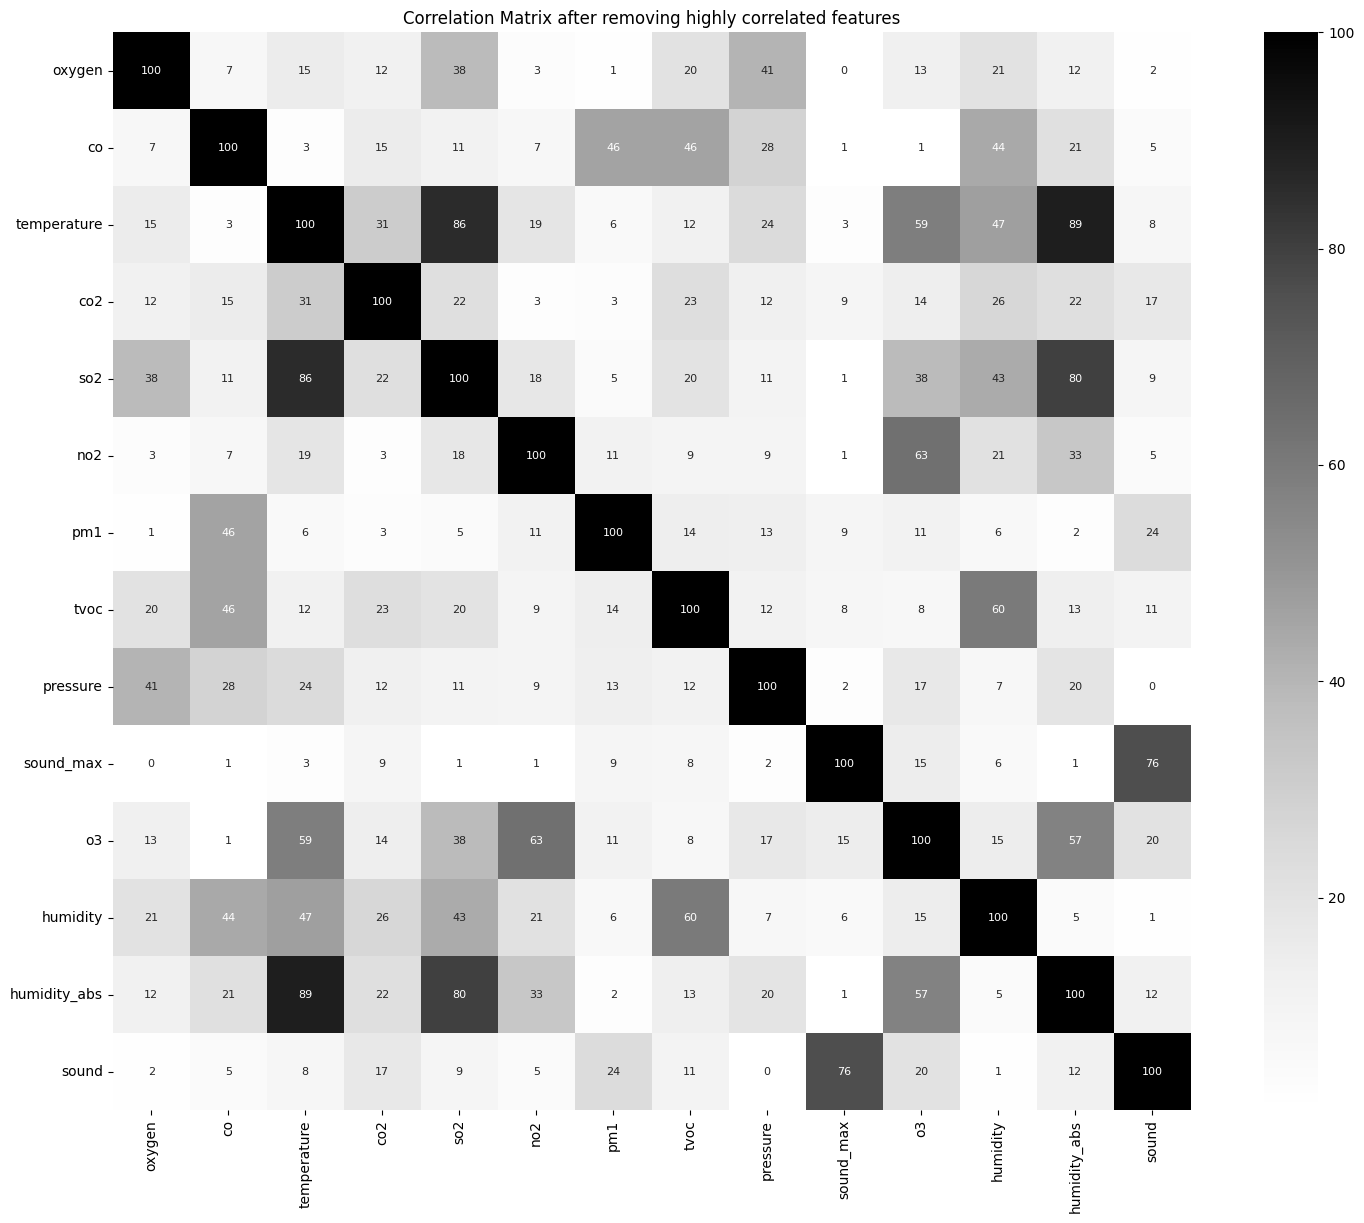

In [9]:
corr = df.corr(min_periods=1000)
high_corr = np.abs(corr)*100
f, ax = plt.subplots(figsize=(19,14))
sns.heatmap(high_corr, cbar=True,annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8},cmap='Greys')
plt.title('Correlation Matrix')
plt.show()

##### drop 99%-100% correlated features

remove_list = ['pm10','pm2_5','dewpt']
features.drop(columns=remove_list,inplace=True)
features1.drop(columns=remove_list,inplace=True)
features2.drop(columns=remove_list,inplace=True)
df1.drop(columns=remove_list,inplace=True)
df2.drop(columns=remove_list,inplace=True)

### for different test set
df2_test_features.drop(columns=remove_list,inplace=True)
df2_test.drop(columns=remove_list,inplace=True)
################################3

corr = features.corr(min_periods=1000)
high_corr = np.abs(corr)*100
f, ax = plt.subplots(figsize=(19,14))
sns.heatmap(high_corr, cbar=True,annot=True, square=True, fmt='.0f', 
            annot_kws={'size': 8},cmap='Greys')
plt.title('Correlation Matrix after removing highly correlated features')
plt.show()


**test Standardization function**

In [10]:
# t = np.array([[[1,2],[3,7]],[[5,6],[7,8]],[[5,6],[7,8]]])
# xt = np.empty(t.shape)
# scalers = {}
# for i in range(t.shape[1]):
#     scalers[i] = StandardScaler()
#     scalers[i].fit(np.unique(t[:, i, :]).reshape(-1,1)) ### as we have overlapping samples
#     xt[:, i, :] = scalers[i].transform(t[:, i, :].reshape(-1,1)).reshape(t.shape[0],t.shape[-1])

# xx,p1,p2 = standardize(t,mode=1)


In [11]:
# ### test standardize
# t = np.array([[[1,2],[3,7]],[[5,6],[7,8]],[[5,6],[7,8]]])
# sh = t.shape
# print(t)
# # print(t - np.array([1,0]).reshape(1,2,1))
# mean = [1,0]
# std = [2,1]
# tt,p1,p2 = standardize(t,mode=2)
# print(tt,p1,p2)
# # print(standardize_with_params(t,mean=p1,std=p2)==tt)

**test sliding over data**

In [12]:
# ### testing sliding
# from functions import *
# _features = pd.DataFrame({'x': [0,1,2,3,4,5,6,7,8,9],'z': [10,11,12,13,14,15,16,17,18,19]})
# _targets = pd.DataFrame({'person': [0,0,1,1,1,0,1,1,0,0],'window_open': [0,1,1,0,1,0,1,0,1,1]}) 
# df3 = pd.concat([_features,_targets],axis=1)
# print(df3)
# # _x,_y= SlidingWindow(3,2,get_x=[0,1],get_y=[2,3],horizon = 0)(df3)
# _x,_y = sliding(3,2,_features,_targets,mode='end')
# print(_x.shape,_y.shape,_x,_y)

**test underSampling**

In [13]:
# ### testing undersampling
# test = pd.DataFrame([[1,2,0,0],[3,4,0,1],[5,6,0,0],[7,8,1,1],[9,10,0,0],[11,12,0,0],[13,14,0,0],[15,16,1,0],[15,16,1,0]],columns=['x','y','person','window_open'])
# print(test)
# t = test.filter(['person','window_open'])
# f = test.drop(columns = ['person','window_open'])
# X,y=under_sample(test,2,2,1)
# print(X.shape,y.shape,'\n',X,y)
# # print(X,y)
# print(X.shape,y.shape)


**Perform undersampling and segmentation**

read yaml config file

In [14]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

under sample and segment

In [15]:
under_window = hyperparams['sample_segment']['under_window']
seq_len = hyperparams['sample_segment']['seq_len']
stride = hyperparams['sample_segment']['stride']
sliding_mode = hyperparams['sample_segment']['sliding_mode']
# standard_mode = 1 ## 1=normalizec, 2= minmax

# reset index 
# df_mini.reset_index(drop=True)
# features_mini.reset_index(drop=True)
# targets.reset_index(drop=True)
#t = df_mini.values
#X, y = SlidingWindow(window_len=window , stride = stride, get_x = [0,1], get_y = [2])(df_mini)

## undersampling and sliding
sampling = hyperparams['sample_segment']['sampling']
if sampling:
    X1,y1= under_sample(df_mini1,under_window,seq_len,stride,sliding_mode=sliding_mode)
    X2,y2= under_sample(df_mini2,under_window,seq_len,stride,sliding_mode=sliding_mode)
else:
    X1,y1= sliding(seq_len,stride,features_mini1,targets1,mode=sliding_mode)
    X2,y2= sliding(seq_len,stride,features_mini2,targets2,mode=sliding_mode)


### standardizing segments after undersampling

# mean,std from dataset after undersampling
# X1_ = standardize_with_params(X1,mean = mean1, std = std1)
# X2_ = standardize_with_params(X2,mean = mean1, std = std2)

# mean,std from dataset before undersampling
# X1_ = standardize_with_params(X1,min = features_mini1.min(axis=0), max = features_mini1.max(axis=0))
# X2_ = standardize_with_params(X2,min = features_mini2.min(axis=0), max = features_mini2.max(axis=0))


##################################################################################################
# # standardize the whole data without undersampling

# features_mini1 = standardize_with_params(features_mini1,mean = features_mini1.mean(axis=0),std = features_mini1.std(axis=0))
# features_mini2 = standardize_with_params(features_mini2,mean = features_mini2.mean(axis=0),std = features_mini2.std(axis=0))

# ## sliding the whole data
# X1_,y1 = sliding(seq_len,stride,features_mini1,targets1)#.loc[:,'person'])
# X2_,y2 = sliding(seq_len,stride,features_mini2,targets2)#.loc[:,'person'])

X = concat(X1,X2)
# X = concat(X1_,X2_)
y = concat(y1,y2)
X.shape, y.shape


((4681, 8, 10), (4681, 2))

**splitting sets and standardization**

**using sklearn**

In [16]:
###### splitting
# splits = TrainValidTestSplitter(valid_size=0.1,test_size=0.1)(y) ##### we have test set here
splits = TrainValidTestSplitter(valid_size=0.1)(y) ##### we DON'T have test set here
x_train = np.zeros(X[splits[0]].shape,dtype=np.float32)
y_train = y[splits[0]]
x_valid = np.zeros(X[splits[1]].shape,dtype=np.float32)
y_valid = y[splits[1]]
# x_test = np.zeros(X[splits[2]].shape,dtype=np.float32)
# y_test = y[splits[2]]

#different test set
### uses stride = 1 to check all time points
x_test_, y_test = sliding(seq_len,1,df2_test_features_mini,df2_test_targets,mode=sliding_mode)
x_test = np.zeros(x_test_.shape,dtype=np.float32) 
#################



#### standardization
scalers = {}
for i in range(x_train.shape[1]): ## n_features
    scalers[i] = StandardScaler()
    scalers[i].fit(np.unique((X[splits[0]])[:, i, :]).reshape(-1,1)) ### as we have overlapping samples
    x_train[:, i, :] = scalers[i].transform((X[splits[0]])[:, i, :].reshape(-1,1)).reshape(x_train.shape[0],x_train.shape[-1])
    x_valid[:, i, :] = scalers[i].transform((X[splits[1]])[:, i, :].reshape(-1,1)).reshape(x_valid.shape[0],x_valid.shape[-1])
    # x_test[:, i, :] = scalers[i].transform((X[splits[2]])[:, i, :].reshape(-1,1)).reshape(x_test.shape[0],x_test.shape[-1]) ## from splitting
    x_test[:, i, :] = scalers[i].transform((x_test_)[:, i, :].reshape(-1,1)).reshape(x_test.shape[0],x_test.shape[-1]) ## test set from outside
print(x_train.shape,x_valid.shape,x_test.shape)

(4213, 8, 10) (468, 8, 10) (191, 8, 10)


**using my functions**

In [17]:
# splits = TrainValidTestSplitter(test_size=0.1)(y)
# x_train,p1,p2 = standardize(X[splits[0]],mode=1)
# y_train = y[splits[0]]
# x_valid = standardize_with_params(X[splits[1]],mean=p1,std=p2)
# y_valid = y[splits[1]]
# x_test = standardize_with_params(X[splits[1]],mean=p1,std=p2)
# y_test = y[splits[2]]
 
# print(x_train.shape,x_valid.shape,x_test.shape)

**plot distribution of data and labels**

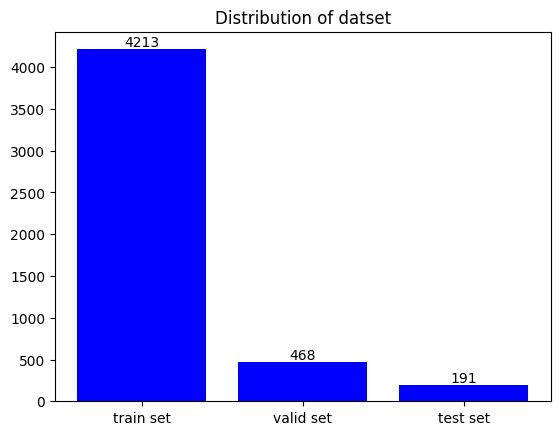

[Text(0, 0, '1099'),
 Text(0, 0, '3582'),
 Text(0, 0, '2847'),
 Text(0, 0, '1834')]

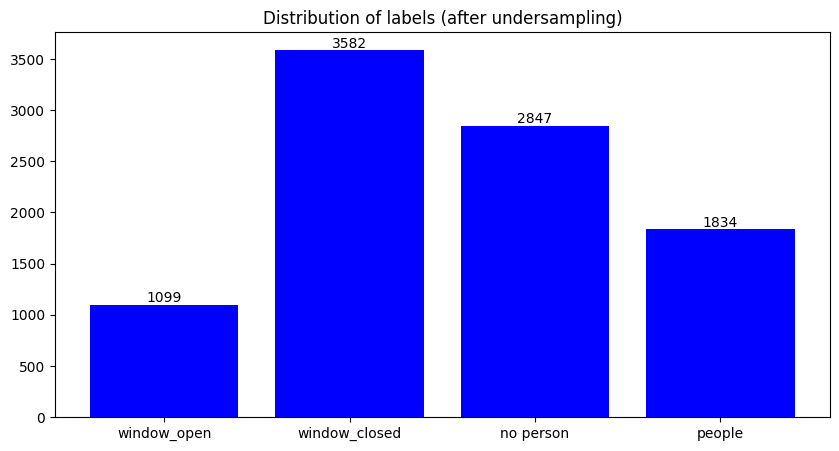

In [18]:

x_lbs = ['train set','valid set','test set']
y_nmrs = [x_train.shape[0],x_valid.shape[0],x_test.shape[0]]

fig, ax = plt.subplots()    
ind = np.arange(len(y_nmrs))  # the x locations for the groups
bars = ax.bar(ind, y_nmrs, color="blue")
ax.set_xticks(ind)
ax.set_xticklabels(x_lbs, minor=False)
plt.title('Distribution of datset')
# plt.xlabel('x')
# plt.ylabel('y')
ax.bar_label(bars)
plt.show()

y_df = pd.DataFrame(y)
y_df.columns = ['person','window_open']
x_lbs = ['window_open','window_closed','no person','people']
y_nmrs = [y_df['window_open'].value_counts()[1],y_df['window_open'].value_counts()[0],y_df['person'].value_counts()[0],y_df['person'].value_counts()[1]]

fig, ax = plt.subplots(figsize=(10,5))    
ind = np.arange(len(y_nmrs))  # the x locations for the groups
bars = ax.bar(ind, y_nmrs, color="blue")
ax.set_xticks(ind)
ax.set_xticklabels(x_lbs, minor=False)
plt.title('Distribution of labels (after undersampling)')
# plt.xlabel('x')
# plt.ylabel('y')
ax.bar_label(bars)

**tsai LEARNER**

read config file

In [22]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

epochs = hyperparams['model']['epochs']
bs = hyperparams['model']['bs']
num_workers = hyperparams['model']['num_workers']

**get pretrained encoder**

In [23]:
pretrained_dict = torch.load(f'models/{AutoEncoder.__name__}_{seq_len}.pt')
new_autoencoder = AutoEncoder(x_train.shape[1])
new_autoencoder.load_state_dict(pretrained_dict)
### get ptrtrained encoder
enc = new_autoencoder.encoder

**Train [note freezing the encoder before fitting]**

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.642816,0.621594,0.685897,00:00
1,0.606217,0.596758,0.685897,00:00
2,0.583212,0.576163,0.685897,00:00
3,0.553415,0.538221,0.692308,00:00
4,0.501944,0.492847,0.722222,00:00
5,0.464872,0.461392,0.772436,00:00
6,0.452766,0.453681,0.772436,00:00
7,0.444332,0.450118,0.776709,00:00
8,0.440071,0.436437,0.797009,00:00
9,0.444307,0.433687,0.794872,00:00


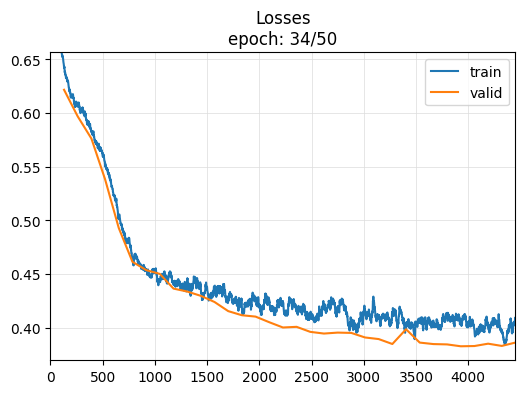

No improvement since epoch 29: early stopping


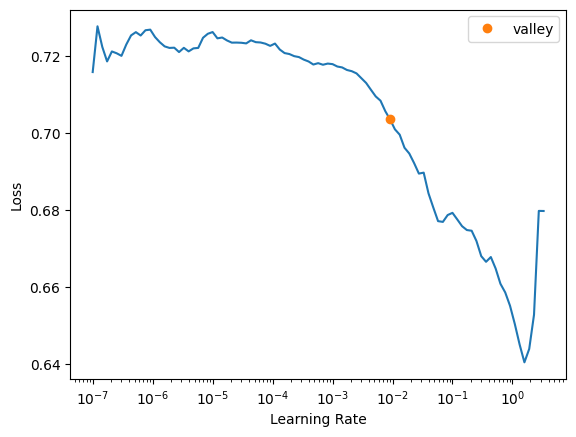

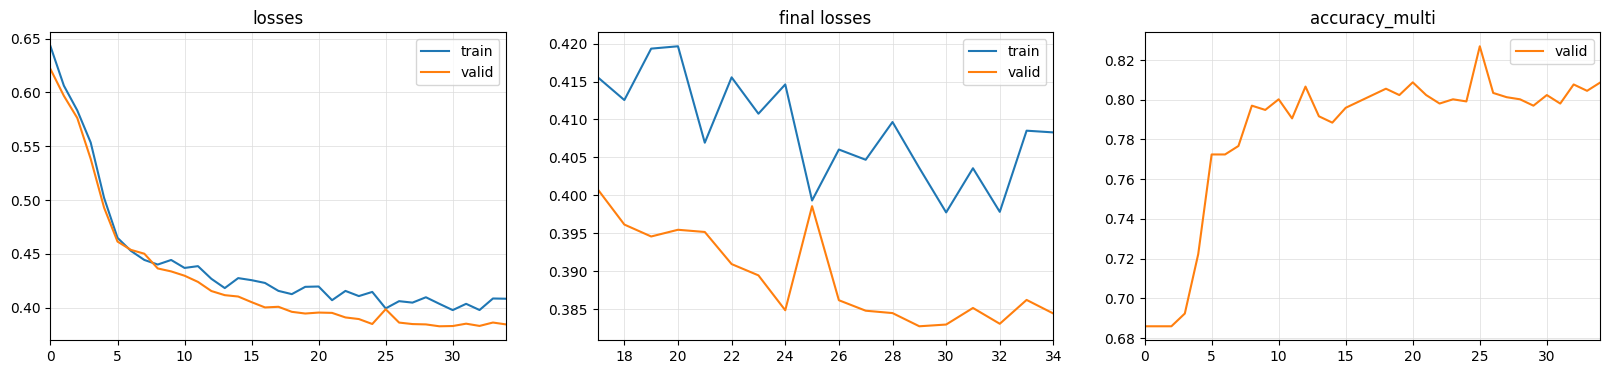

time= 36.10421681404114
No. of trainable parameters= 302
train loss = 0.4082961082458496, valid loss = 0.3843938708305359
FlattenedLoss of BCEWithLogitsLoss()


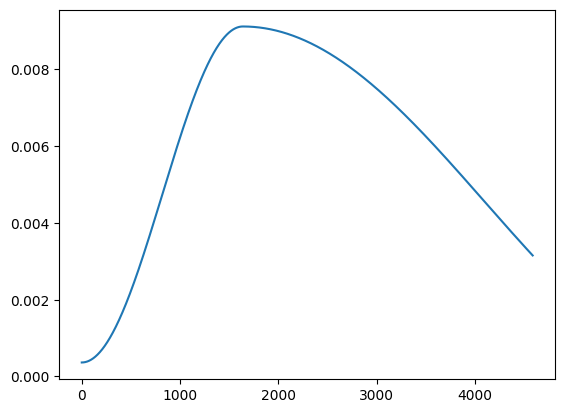

In [24]:
######## remove sigmoid from the network*****************

# splits = TimeSplitter()(y)
# tfms  = [None, Categorize()] ## single label
tfms  = [None, MultiCategorize()] ## multi label
batch_tfms = TSStandardize()

## single label
# tsets = TSDatasets(x_train, y_train[:,0], tfms=tfms, inplace=True)
# vsets = TSDatasets(x_valid, y_valid[:,0], tfms=tfms, inplace=True)
## multi label
tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)
######################
dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

#### use batch normalization instead
# dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs = 32, num_workers=2,batch_tfms=batch_tfms) ### note the normalization

# k={'shuffle':False} ## for LSTM_FCN
# k={'layers':[16,16,16],'kss':[7,5,3]}
#############################################################
# k = {'hidden_size':22,'rnn_dropout':0.4}
# k={'layers':[32,8]}
k={'encoder':enc,'n_neurons':50}
model = create_model(EncoderClassifier, dls.vars,dls.c,dls,**k)
# learn = Learner(dls, model, metrics=accuracy,cbs = ShowGraph()) ### single label
#### note the accuracy_multi and MultiCategorize() contains BCEwithlogits not normal BCE
learn = Learner(dls, model, metrics=accuracy_multi,cbs = ShowGraph()) ### multi label
##########################################################################3

freeze(learn)  #### freeze encoder

###########################################################################
start = time.time()
learn.fit_one_cycle(epochs,learn.lr_find().valley,cbs = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5)) ## learning rate annealing
elapsed = time.time()-start
print(f'time= {elapsed}')
print(f'No. of trainable parameters= {count_parameters(model)}')
print(f'train loss = {learn.recorder.values[-1][0]}, valid loss = {learn.recorder.values[-1][1]}')
plt.figure()
plt.plot(learn.recorder.lrs)

print(learn.loss_func)
metrics = np.array(learn.recorder.values)

# save the model as state dictionary 
torch.save(learn.model.state_dict(), f'models/{learn.model._get_name()}.pt')
#### unfreeze encoder
unfreeze(learn) 
##### save and load pkl model
# learn.export('models/learn.pkl')
# learn = load_learner('models/learn.pkl')

**get train loss, valid loss and accuracy**

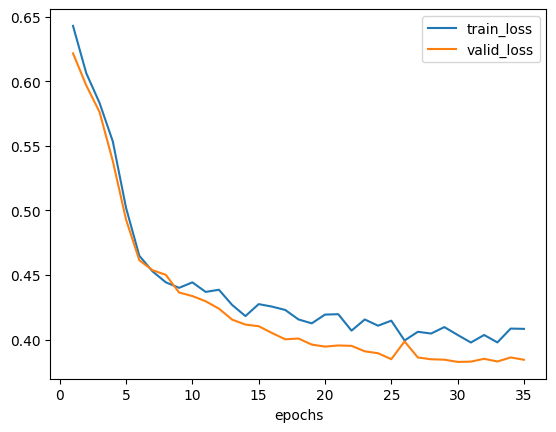

In [25]:
plt.figure()
xx = range(1,learn.epoch+2) ### epochs number after early stopping
plt.plot(xx,metrics[:,0],label='train_loss')
plt.plot(xx,metrics[:,1],label = 'valid_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

**EVALUATION ON TEST DATA SET + Using PR curves**

Best Threshold=0.702377, F1-Score=0.897


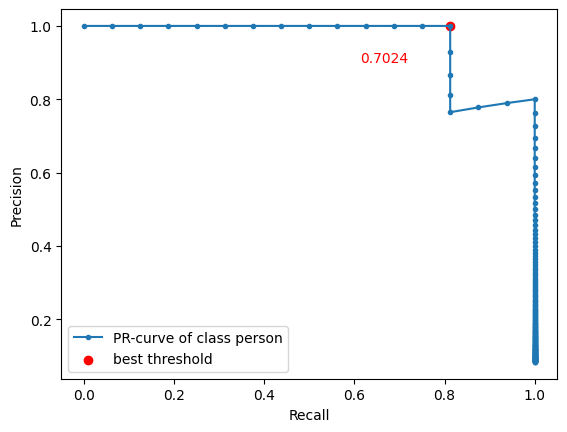

Best Threshold=0.491187, F1-Score=1.000


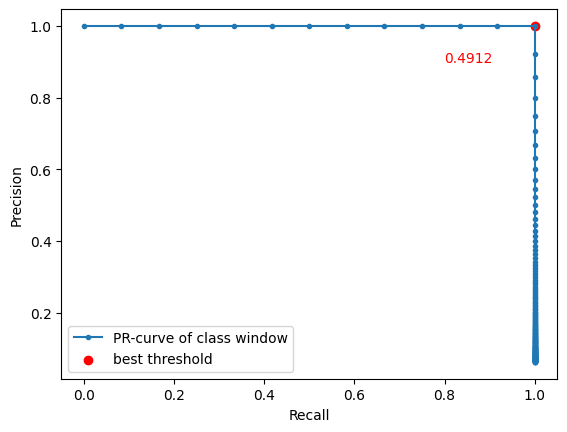

Accuracy [Both]: 98.42932
Accuracy [person]: 98.42932
Accuracy [window_open]: 100.00000


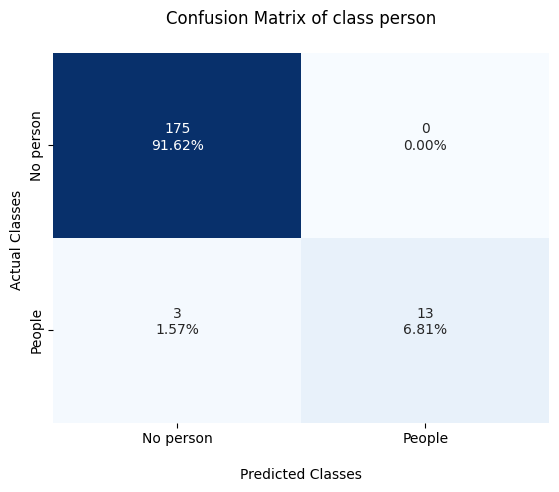

F1 score: 0.896551724137931

precision: 1.0

recall: 0.8125



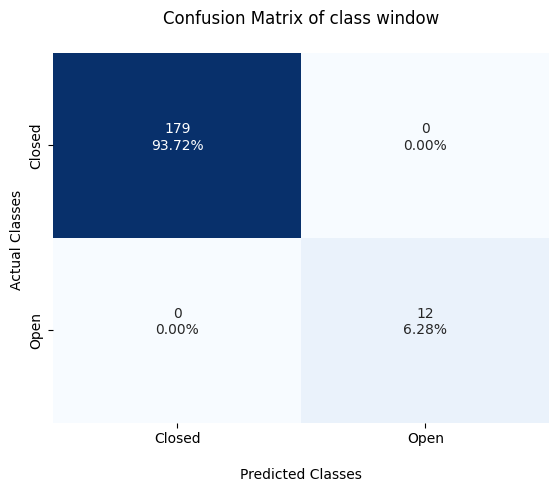

F1 score: 1.0

precision : 1.0

recall : 1.0



In [26]:
#### Adding dataset to apply same dls valid tfms on test

### standardize test set with train parameters (apply Multicategorize transform)
test_set = TSDatasets(x_test, y_test, tfms=tfms, inplace=True) # multi_label
# test_set = TSDatasets(x_test, y_test[:,0], tfms=tfms, inplace=True) # single_label
test_dl   = TSDataLoader(test_set, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization
# next(iter(test_dl))
 
# apply transforms as in valid data set, but each with its own parameters
# test_ds = dls.valid.dataset.add_test(X[splits[2]], y[splits[2]]) #X and y would be your test data (segmented)
# test_dl = dls.valid.new(test_ds)
# next(iter(test_dl))

#### evaluating

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,with_decoded=True)#,reorder = False)
test_preds = test_preds.long() ### to convert bool to int

###############################################################################################
###### use PR curve to get best threshold for each class on given test set
##############################################################################################
# class person
threshold_person, _ = plot_PR_curve('person',test_targets[:,0],test_probas[:,0])
### class window_open
threshold_window, _ =plot_PR_curve('window',test_targets[:,1],test_probas[:,1])
test_preds[:,0] = (test_probas[:,0]>=threshold_person)
test_preds[:,1] = (test_probas[:,1]>=threshold_window)
#################################################################################################

## single label
### number of classes in validation set
# n_classes = pd.DataFrame(test_targets).value_counts().shape[0]
# plot_confusion(test_targets,test_preds,n_classes,name = 'person')
# print(f'Accuracy: {(test_targets == test_preds).float().mean():0.5f}')  
# print(f'F1 score: {f1_score(test_targets,test_preds)}\n') # to get f1 score for each class use (average=None)
# print(f'precision: {precision_score(test_targets,test_preds)}\n') 
# print(f'recall: {recall_score(test_targets,test_preds)}\n') 

## multi label
print(f'Accuracy [Both]: {(100/test_targets.shape[0])*torch.all((test_preds == test_targets),dim=1).sum():0.5f}') ## multi-label
print(f'Accuracy [person]: {(100/test_targets.shape[0])*(test_preds[:,0] == test_targets[:,0]).sum():0.5f}') ## multi-label
print(f'Accuracy [window_open]: {(100/test_targets.shape[0])*(test_preds[:,1] == test_targets[:,1]).sum():0.5f}') ## multi-label
n_classes = test_targets.shape[1]

## person class
plot_confusion(test_targets[:,0],test_preds[:,0],n_classes,name = 'person')
print(f'F1 score: {f1_score(test_targets[:,0],test_preds[:,0])}\n')
print(f'precision: {precision_score(test_targets[:,0],test_preds[:,0])}\n') 
print(f'recall: {recall_score(test_targets[:,0],test_preds[:,0])}\n') 

### window class
plot_confusion(test_targets[:,1],test_preds[:,1],n_classes,name = 'window')
print(f'F1 score: {f1_score(test_targets[:,1],test_preds[:,1])}\n') 
print(f'precision : {precision_score(test_targets[:,1],test_preds[:,1])}\n') 
print(f'recall : {recall_score(test_targets[:,1],test_preds[:,1])}\n') 


**new metric based on weighted normalized kullback leibler divergence**

In [27]:
### person class
p = test_preds[:,0]
t = test_targets[:,0]
kl_score_person = ((normalized_kl(t,p) + normalized_kl(p, t))/2).item() ## to be symmetric
### window class
p = test_preds[:,1]
t = test_targets[:,1]
kl_score_window = ((normalized_kl(t,p) + normalized_kl(p, t))/2).item() ## to be symmetric
print (f'kl_score for person class= {kl_score_person} \n kl_score for window class= {kl_score_window}') 

kl_score for person class= 0.9213680028915405 
 kl_score for window class= 1.0


**investigate distribution of wrong predictions** 

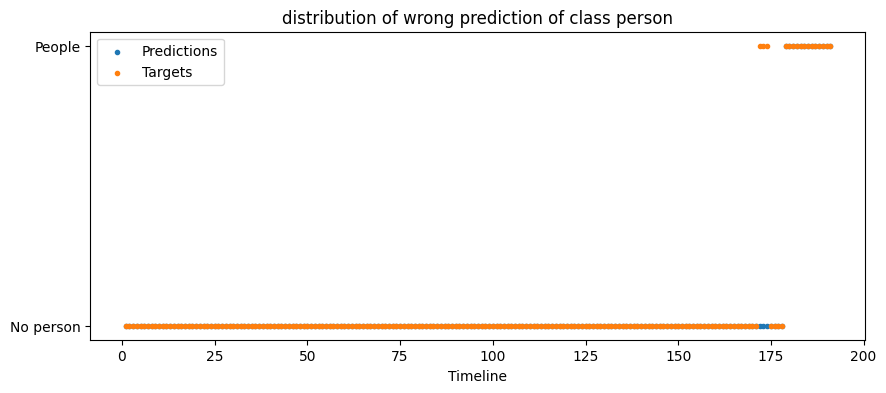

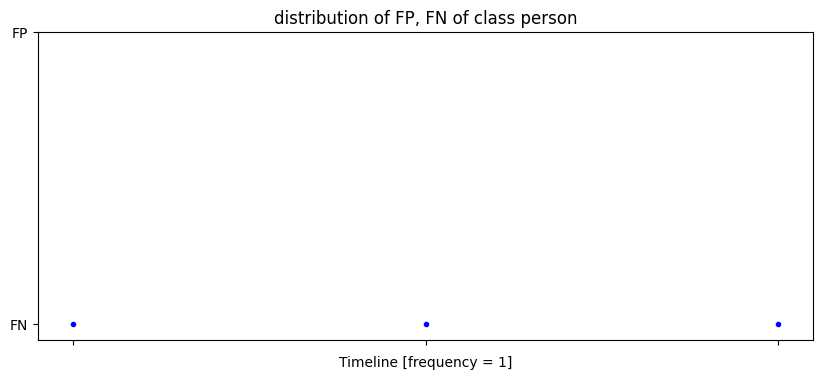

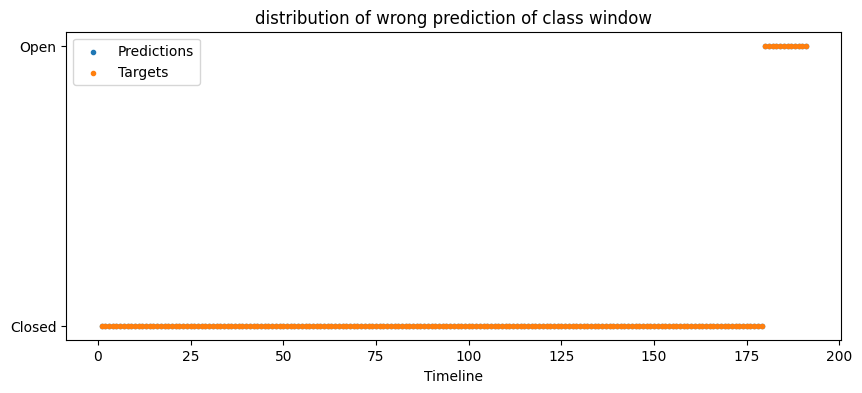

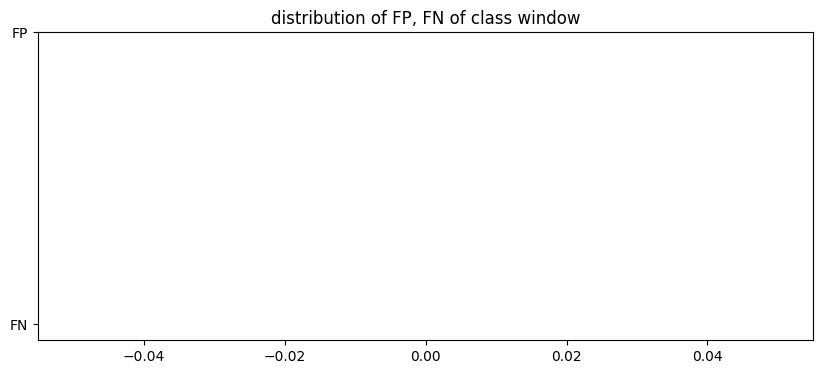

In [28]:
#### single label
# ## plot targets vs predictions person
# plot_distribution(test_targets,test_preds,'person')
# ## plot FP, FN 
# plot_fp_fn(test_targets,test_preds,'person')


#### multi label
## plot targets vs predictions person
plot_distribution(test_targets[:,0],test_preds[:,0],'person')
## plot FP, FN 
plot_fp_fn(test_targets[:,0],test_preds[:,0],'person')

## plot targets vs predictions window
plot_distribution(test_targets[:,1],test_preds[:,1],'window')
## plot FP, FN 
plot_fp_fn(test_targets[:,1],test_preds[:,1],'window')


**visualizing features in a lower dimensional space [note output of encoder]**

In [34]:
##### testing dataloaders
tfms  = [None, MultiCategorize()] ## multi label
test_set = TSDatasets(x_test, y_test, tfms=tfms, inplace=True) # multi_label
test_dl   = TSDataLoader(test_set, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

###############################
#### creating only body of the network for lstm,fcn
################################################
# k_lstm = {'c_in':x_train.shape[1],'c_out':y_train.shape[1],'hidden_size':22,'rnn_dropout':0.4}
# k_fcn={'c_in':x_train.shape[1],'c_out':y_train.shape[1],'layers':[32,8]}
# # new_model = create_model(LSTM_body, dls.vars,dls.c,dls,**k)

# # new_model = LSTM_body(**k_lstm)  ## LSTM
# new_model = MyFCN_body(**k_fcn)    ## MyFCN

# #### load part of the pre trained model

# # load 
# pretrained_dict = torch.load(f'models/{learn.model._get_name()}.pt')
# model_dict = new_model.state_dict()
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# new_model.load_state_dict(model_dict)
#######################################################

new_model = enc ##### for encoder_classifier

###########################################
###### get the features/predicions of the model_body
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_model.to(device)
new_model.eval()
feats = []
lbls = []
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = new_model(inputs)
        #####################################################
        feats.append(outputs[:,-1]) #### for output of encoder
        #######################################################
        # feats.append(outputs)  ### for lstm, fcn
        #######################################################
        lbls.append(labels)

test_feats = torch.cat(feats).detach().cpu().numpy()
test_lbls = torch.cat(lbls).detach().cpu().numpy()

#### get labels as strings
person_labels = []
person_dict = {1 : 'people', 0 : 'no person'}
window_labels = []
window_dict = {1 : 'open', 0 : 'closed'}
for item in test_lbls:
    person_labels.append(person_dict[item[0]])
    window_labels.append(window_dict[item[1]])

##########
# using tensorboard projector
# writer = SummaryWriter('runs/')
# writer.add_embedding(test_feats,metadata=person_labels,tag = f'person_embeddings_{learn.model._get_name()}')
# writer.add_embedding(test_feats,metadata=window_labels,tag = f'window_embeddings_{learn.model._get_name()}')
# writer.close()
##########
### using sklearn and plotly
components = visualize_embeddings(test_feats,person_labels,window_labels,n_components=2,method='pca')


**optuna for HP optimization**

load yaml file

In [ ]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

optimize

In [43]:
epochs = hyperparams['optuna']['epochs']
optuna_trials = hyperparams['optuna']['trials']
bs = hyperparams['model']['bs']
num_workers = hyperparams['model']['num_workers']

tfms  = [None, MultiCategorize()] 
batch_tfms = TSStandardize()


tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
vsets = TSDatasets(x_test, y_test, tfms=tfms, inplace=True)
dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization


def objective(trial:optuna.Trial):
    # Define search space here. Supported search space are 
    
    # filters_1 = trial.suggest_int('filters_1',8,32,step = 4) 
    # filters_2 = trial.suggest_int('filters_2',8,32,step = 4) 
    rnn_dropout = trial.suggest_float("rnn_dropout", 0.1, 0.5, step = 0.1)
    hidden_size = trial.suggest_int('hidden_size',10,30,step = 2)
    
    # n_filters = trial.suggest_categorical('num_filters', [8,16,24,32]) 
    # lr = trial.suggest_float("Learning_rate", 1e-8, 1e-6, log=True)
    # k={'fc_dropout': dropout_rate}

    k = {'hidden_size':hidden_size,'rnn_dropout':rnn_dropout}
    # k={'layers':[filters_1,filters_2]}
    model = create_model(LSTM, dls.vars,dls.c,dls,**k)
    #### note the F1_multi and MultiCategorize() contains BCEwithlogits not normal BCE
    learn = Learner(dls, model, metrics=F1_multi)
    
    learn.fit_one_cycle(epochs,learn.lr_find().valley) ## learning rate annealing
            
    # return the F1 score - learn.recorder.values returns [[train_loss, valid_loss, F1_multi]]
    return learn.recorder.values[-1][-1]

    # return the valid_loss - learn.recorder.values returns [[train_loss, valid_loss, acc]]
    # return learn.recorder.values[-1][1]

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=optuna_trials, show_progress_bar=False)

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  44
Best trial:
  Value:  0.21500743925571442
  Params: 
    rnn_dropout: 0.2
    hidden_size: 26


**Benchmarking**

In [ ]:
dsid = 'LSST' 

tfms  = [None, MultiCategorize()] 
batch_tfms = TSStandardize()
tsets = TSDatasets(x_train, y_train, tfms=tfms, inplace=True)
vsets = TSDatasets(x_valid, y_valid, tfms=tfms, inplace=True)
dls   = TSDataLoaders.from_dsets(tsets, vsets, bs = 32, num_workers=2)#,batch_tfms=batch_tfms) ### note the normalization


archs = [(FCN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}),
         (InceptionTime, {})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch,dls.vars,dls.c, dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy_multi)
    start = time.time()
    learn.fit_one_cycle(10, learn.lr_find().valley)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    display(results)

**calculate time**

In [ ]:
import timeit

start = timeit.default_timer()



 
learn = TSClassifier(X, y, splits=splits, lr=1e-5,path='models', arch=LSTMPlus , batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(10)
stop = timeit.default_timer()

print('Time: ', stop - start) 

**test custom torch datasets and dataloaders**

In [ ]:
# ds = MyDataSet(X,y,transform=ToTensor())
# bs = 32

# splits = TrainValidTestSplitter()(y)

# tsets = MyDataSet(X[splits[0]], y[splits[0]])#, transform=tfms) #train dataset
# vsets = MyDataSet(X[splits[1]], y[splits[1]])#, transform=tfms) #valid dataset

# tls = DataLoader(tsets, batch_size=bs, shuffle=False, num_workers=2)
# vls = DataLoader(vsets, batch_size=bs, shuffle=False, num_workers=2)
# classes = ('person','window_open')


**Train**

In [ ]:
# # model = ConvNet(X.shape[1],y.shape[1]).to(device)

#standardize train set, then use params to standardize valid and test
# for MyLearner this is done internally

### standardization using my functions
# x_train,p1,p2 = standardize(X[splits[0]],mode=1)
# x_valid = standardize_with_params(X[splits[1]],mean=p1,std=p2)



model = MyFCN(X.shape[1],y.shape[1])
learn = MyLearner(x_train,y_train,x_valid,y_valid,model) #### normalize
learn.fit(30)

# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)



**evaluate on test data**

In [ ]:
learn.eval(x_test,y_test)

**SMOTE Oversampling (destroys the time series !!!)**

In [ ]:
# from imblearn.over_sampling import SMOTE,KMeansSMOTE
# from sklearn.model_selection import train_test_split

# ##### NOTE THE SHUFFLE AND TIME SERIES
# x_train, x_valid, y_train, y_valid = train_test_split(df_mini.iloc[:,0:-1], df_mini.iloc[:,-1], test_size=0.2, shuffle=False)

# print(y_train.value_counts())
# ### get array of dataset train and target

# # train = to_np(dsets.train[:][0])
# # tar = to_np(dsets.train[:][1])
# # print(tar.shape,train.shape)


# ### Apply SMOTE only on train dataset to avoid data leakage
# sm = SMOTE(random_state=42,sampling_strategy={1:20000,2:10000})

# x_res, y_res = sm.fit_resample(x_train, y_train)
# print(y_res.value_counts())

# ### create sliding windows
# x_train,y_train = sliding(window,stride,x_res,y_res)
# x_valid,y_valid = sliding(window,stride,x_valid,y_valid)
# print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

